In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve


def plot(image):
    plt.figure()
    plt.imshow(image.reshape((32, 32))
               if image.shape[0] != 32 else image, cmap="gray")
    plt.show()


def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    fig = plt.figure(figsize=(6.5, 6.5))
    plt.imshow(cm, interpolation="none", cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    # return fig


# Get data

In [2]:
import keras.datasets.cifar10 as cifar10

(Xtrain, ytrain), (Xtest, ytest) = cifar10.load_data()

# Transform data into array from 1-col matrix
ytrain = ytrain.squeeze()
ytest = ytest.squeeze()

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


# Randomize train data and sort test data

In [3]:
idx = rnd.permutation(Xtrain.shape[0])
Xtrain = Xtrain[idx]
ytrain = ytrain[idx]

idx = np.argsort(ytest)
Xtest = Xtest[idx]
ytest = ytest[idx]


# Convert images to grayscale
We're converting the images to grayscale to improve the performance of the classification. We're expecting that the performance is worse than with colored images because there are some images that would be easier to classify according to color. For example, we would expect the model to identify the blue around the ship or the plane to better distiguish them from the others

In [4]:
from skimage import color

XtrainG = np.zeros((Xtrain.shape[0], 32, 32))
for i in range(Xtrain.shape[0]):
    XtrainG[i] = color.rgb2gray(Xtrain[i])

XtestG = np.zeros((Xtest.shape[0], 32, 32))
for i in range(Xtest.shape[0]):
    XtestG[i] = color.rgb2gray(Xtest[i])


# Convert images to vectors

In [5]:
XtrainG = XtrainG.reshape((XtrainG.shape[0], XtrainG.shape[1] ** 2)) * 1.0
XtestG = XtestG.reshape((XtestG.shape[0], XtestG.shape[1] ** 2)) * 1.0

print(XtrainG.shape, ytrain.shape)
print(XtestG.shape, ytest.shape)


(50000, 1024) (50000,)
(10000, 1024) (10000,)


# Normalization

In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler().fit(XtrainG)
XtrainGS = ss.transform(XtrainG)
XtestGS = ss.transform(XtestG)


# Binarize for ship (index 8)

In [7]:
ytrainB = (ytrain == 8) * 1
ytestB = (ytest == 8) * 1


#### Change names

In [8]:
X1 = XtrainG
X1s = XtrainGS
y1 = ytrain
y1b = ytrainB
X2 = XtestG
X2s = XtestGS
y2 = ytest
y2b = ytestB


# Binary classification

## SGDClassifier

In [9]:
from sklearn.linear_model import SGDClassifier


### Not normalized data

Score: 0.9
Number of errors: 1000
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9000
           1       0.50      0.02      0.04      1000

    accuracy                           0.90     10000
   macro avg       0.70      0.51      0.49     10000
weighted avg       0.86      0.90      0.86     10000



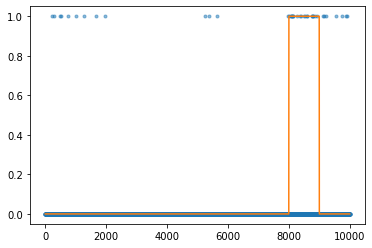

Prediction
[[8980   20]
 [ 980   20]]


In [10]:
sgdb = SGDClassifier().fit(X1, y1b)
y2e = sgdb.predict(X2)

print('Score:', sgdb.score(X2, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

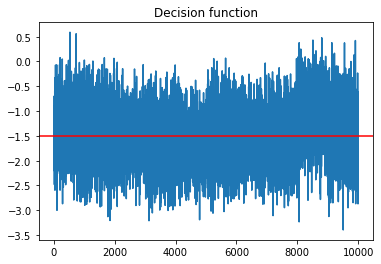

Decision function with threshold = -1.5
[[4251 4749]
 [ 144  856]]


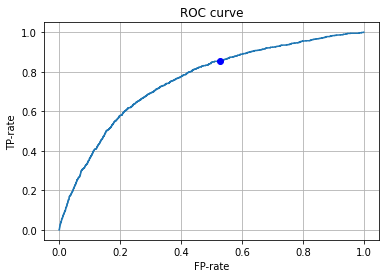

In [11]:
th = -1.5
y2d = sgdb.decision_function(X2)

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


### Normalized data

Score: 0.8944
Number of errors: 1056
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      9000
           1       0.20      0.02      0.03      1000

    accuracy                           0.89     10000
   macro avg       0.55      0.50      0.49     10000
weighted avg       0.83      0.89      0.85     10000



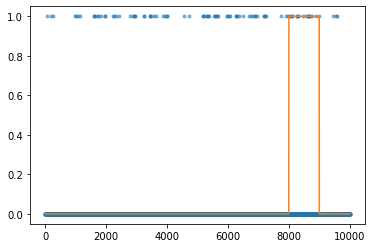

Prediction
[[8926   74]
 [ 982   18]]


In [12]:
sgdbn = SGDClassifier().fit(X1s, y1b)
y2e = sgdbn.predict(X2s)

print('Score:', sgdbn.score(X2s, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

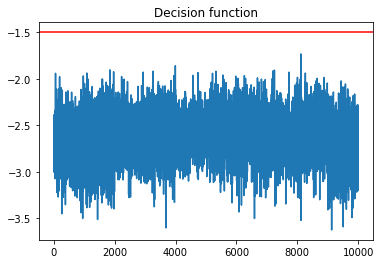

Decision function with threshold = -1.5
[[9000    0]
 [1000    0]]


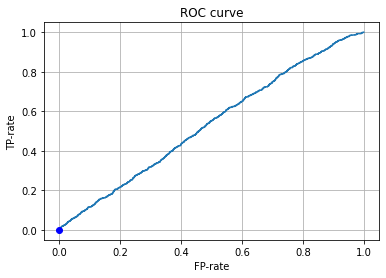

In [13]:
th = -1.5
y2d = sgdbn.decision_function(X2)

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


We can see that without any normalization, the classifier doesn't guess any image as ship, resulting in a score of 0.9 because every other class isn't a ship.
With normalization, the classifier was able to guess some of the images as ship, despite getting a bit more errors

# Multi-class classification

We decided to use the SGDClassifier because it takes a significant less amount of time to train comparing to the RandomForestClassifier

### Not normalized data

Score: 0.2318
Number of errors: 7682
              precision    recall  f1-score   support

           0       0.20      0.57      0.30      1000
           1       0.50      0.19      0.27      1000
           2       0.13      0.10      0.12      1000
           3       0.16      0.20      0.18      1000
           4       0.17      0.22      0.19      1000
           5       0.42      0.13      0.20      1000
           6       0.33      0.04      0.07      1000
           7       0.21      0.30      0.25      1000
           8       0.32      0.13      0.19      1000
           9       0.37      0.43      0.40      1000

    accuracy                           0.23     10000
   macro avg       0.28      0.23      0.22     10000
weighted avg       0.28      0.23      0.22     10000



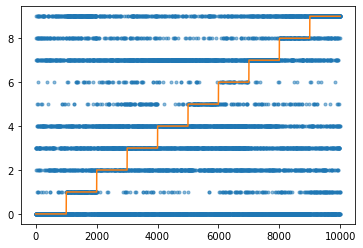

Prediction
Confusion matrix, without normalization


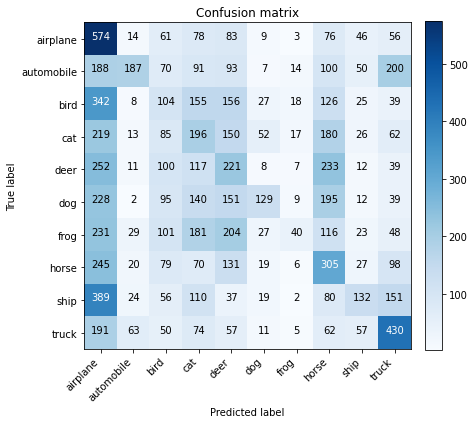

In [14]:
sgd = SGDClassifier().fit(X1, y1)
y2e = sgd.predict(X2)

print('Score:', sgd.score(X2, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Score: 0.1882
Number of errors: 8118
              precision    recall  f1-score   support

           0       0.09      0.05      0.07      1000
           1       0.26      0.26      0.26      1000
           2       0.16      0.13      0.15      1000
           3       0.12      0.06      0.08      1000
           4       0.09      0.14      0.11      1000
           5       0.21      0.19      0.20      1000
           6       0.18      0.37      0.24      1000
           7       0.18      0.06      0.09      1000
           8       0.25      0.26      0.26      1000
           9       0.29      0.36      0.33      1000

    accuracy                           0.19     10000
   macro avg       0.18      0.19      0.18     10000
weighted avg       0.18      0.19      0.18     10000



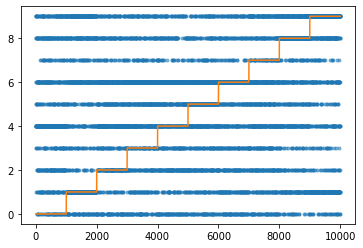

Prediction
Confusion matrix, without normalization


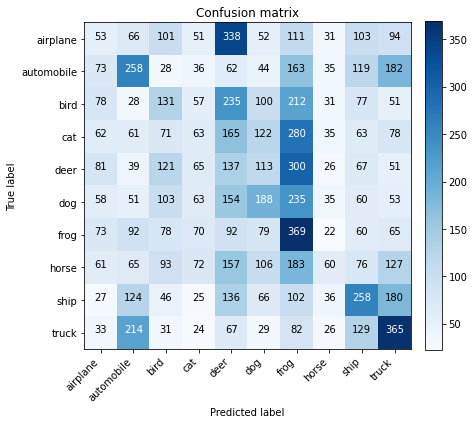

In [15]:
sgdn = SGDClassifier().fit(X1s, y1)
y2e = sgdn.predict(X2s)

print('Score:', sgdn.score(X2s, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


We can see that in the multi-class classification, the classifier performed better with the data normalized

### Validation
We'll use only the train data to estimate the performance of the classifier and compare. We'll be using the normalized data because of the better performance

In [16]:
from sklearn.model_selection import train_test_split


Score: 0.1865
Number of errors: 8135
              precision    recall  f1-score   support

           0       0.14      0.09      0.11      1000
           1       0.25      0.15      0.19      1000
           2       0.16      0.18      0.17      1000
           3       0.12      0.17      0.14      1000
           4       0.16      0.20      0.17      1000
           5       0.17      0.12      0.14      1000
           6       0.19      0.16      0.18      1000
           7       0.19      0.23      0.21      1000
           8       0.20      0.12      0.15      1000
           9       0.27      0.47      0.34      1000

    accuracy                           0.19     10000
   macro avg       0.18      0.19      0.18     10000
weighted avg       0.18      0.19      0.18     10000



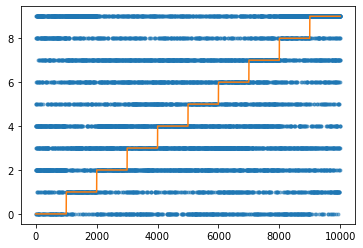

Prediction
Confusion matrix, without normalization


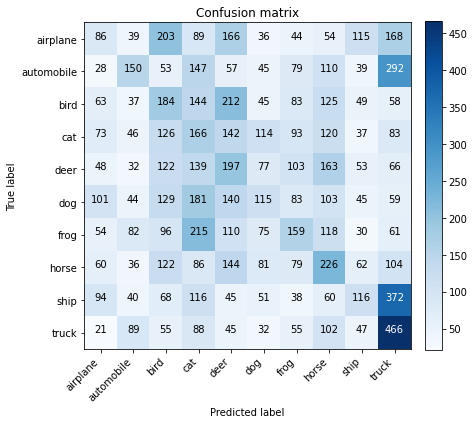

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X1s, y1, stratify=y1, test_size=0.2)

# Randomize new train data
idx = rnd.permutation(X_train.shape[0])
X_train = X_train[idx]
y_train = y_train[idx]

# Order new test data
idx = np.argsort(y_test)
X_test = X_test[idx]
y_test = y_test[idx]

sgdn = SGDClassifier().fit(X_train, y_train)
y_test_e = sgdn.predict(X_test)

print('Score:', sgdn.score(X_test, y_test))
print("Number of errors:", np.sum(y_test != y_test_e))
print(classification_report(y_test, y_test_e))

plt.figure()
plt.plot(y_test_e, ".", alpha=0.5)
plt.plot(y_test)
plt.show()

print('Prediction')
cm = confusion_matrix(y_test, y_test_e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


We can see that the validation performed in a very similar way to the test as we were expecting

## PCA
The images are in grayscale and are already with a low resolution. We're expecting that the PCA will impact the classification because the images already have low information and reducing the dimensionality will worsen the performance

In [18]:
from sklearn.decomposition import PCA


### Not normalized data

Score: 0.2154
Number of errors: 7846
              precision    recall  f1-score   support

           0       0.16      0.12      0.14      1000
           1       0.27      0.36      0.31      1000
           2       0.13      0.08      0.10      1000
           3       0.16      0.12      0.14      1000
           4       0.14      0.15      0.14      1000
           5       0.25      0.37      0.29      1000
           6       0.16      0.12      0.14      1000
           7       0.23      0.27      0.25      1000
           8       0.25      0.32      0.28      1000
           9       0.30      0.25      0.27      1000

    accuracy                           0.22     10000
   macro avg       0.20      0.22      0.21     10000
weighted avg       0.20      0.22      0.21     10000



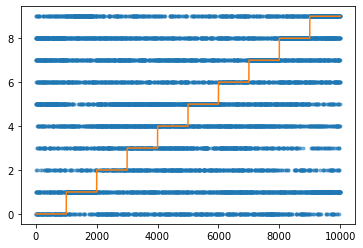

Prediction
Confusion matrix, without normalization


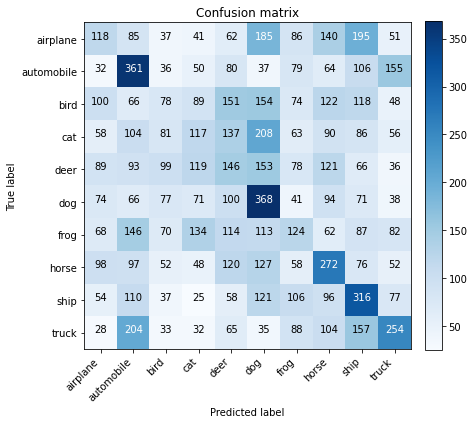

In [19]:
# Try different number of components
pca = PCA(n_components=None).fit(X1)
X1p = pca.transform(X1)
X2p = pca.transform(X2)

sgd = SGDClassifier().fit(X1p, y1)
y2e = sgd.predict(X2p)

print('Score:', sgd.score(X2p, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


### Normalized data

Score: 0.1786
Number of errors: 8214
              precision    recall  f1-score   support

           0       0.20      0.18      0.19      1000
           1       0.25      0.31      0.28      1000
           2       0.16      0.09      0.11      1000
           3       0.12      0.14      0.13      1000
           4       0.11      0.15      0.13      1000
           5       0.20      0.23      0.21      1000
           6       0.16      0.12      0.13      1000
           7       0.17      0.19      0.18      1000
           8       0.18      0.11      0.13      1000
           9       0.23      0.27      0.25      1000

    accuracy                           0.18     10000
   macro avg       0.18      0.18      0.18     10000
weighted avg       0.18      0.18      0.18     10000



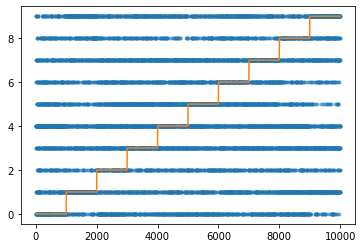

Prediction
Confusion matrix, without normalization


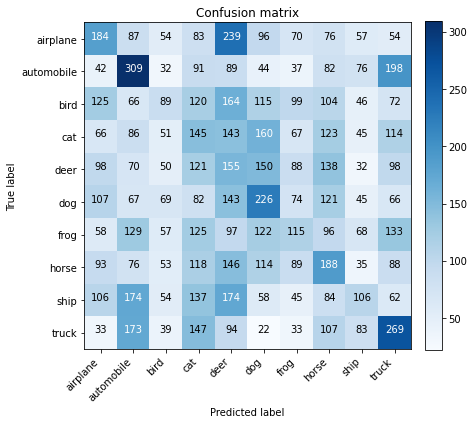

In [20]:
# Try different number of components
pca = PCA(n_components=None).fit(X1s)
X1sp = pca.transform(X1s)
X2sp = pca.transform(X2s)

sgdn = SGDClassifier().fit(X1sp, y1)
y2e = sgdn.predict(X2sp)

print('Score:', sgdn.score(X2sp, y2))
print("Number of errors:", np.sum(y2 != y2e))
print(classification_report(y2, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2)
plt.show()

print('Prediction')
cm = confusion_matrix(y2, y2e)
# print(cm)

plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


## RandomForestClassifier
why

In [21]:
from sklearn.ensemble import RandomForestClassifier


### Not normalized data

Score: 0.9138
Number of errors: 862
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9000
           1       0.80      0.18      0.30      1000

    accuracy                           0.91     10000
   macro avg       0.86      0.59      0.63     10000
weighted avg       0.90      0.91      0.89     10000



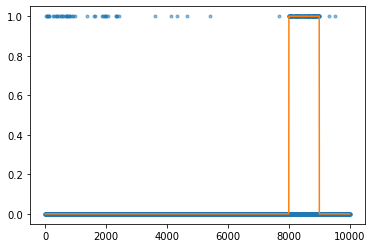

Prediction
[[8953   47]
 [ 815  185]]


In [22]:
rfcb = RandomForestClassifier().fit(X1, y1b)
y2e = rfcb.predict(X2)

print('Score:', rfcb.score(X2, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

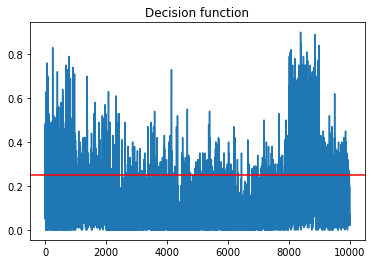

Decision function with threshold = 0.25
[[8218  782]
 [ 426  574]]


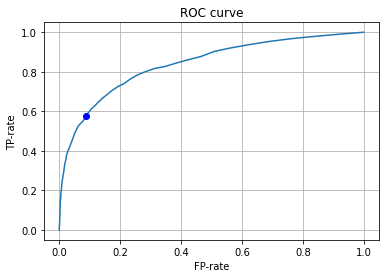

In [23]:
th = 0.25
y2d = rfcb.predict_proba(X2)[:, 1]

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


### Normalized data

Score: 0.9123
Number of errors: 877
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      9000
           1       0.78      0.17      0.28      1000

    accuracy                           0.91     10000
   macro avg       0.85      0.58      0.62     10000
weighted avg       0.90      0.91      0.89     10000



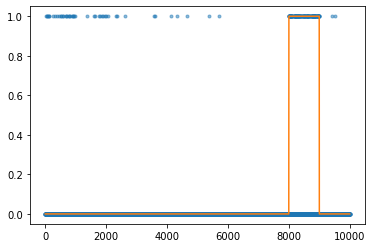

Prediction
[[8953   47]
 [ 830  170]]


In [24]:
rfcbn = RandomForestClassifier().fit(X1s, y1b)
y2e = rfcbn.predict(X2s)

print('Score:', rfcbn.score(X2s, y2b))
print("Number of errors:", np.sum(y2b != y2e))
print(classification_report(y2b, y2e))

plt.figure()
plt.plot(y2e, ".", alpha=0.5)
plt.plot(y2b)
plt.show()

print('Prediction')
cm = confusion_matrix(y2b, y2e)
print(cm)


#### Decision function

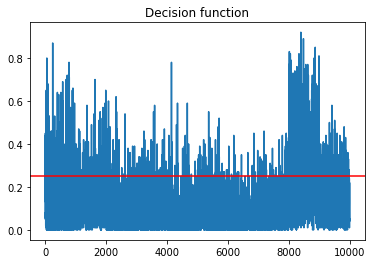

Decision function with threshold = 0.25
[[8210  790]
 [ 427  573]]


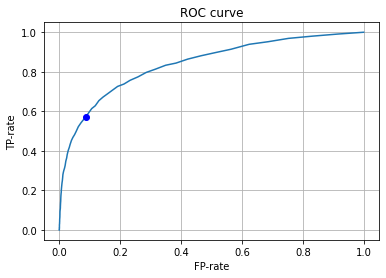

In [25]:
th = 0.25
y2d = rfcbn.predict_proba(X2s)[:, 1]

plt.figure()
plt.plot(y2d)
plt.axhline(th, color='r')
plt.title("Decision function")
plt.show()

print(f'Decision function with threshold = {th}')
cm = confusion_matrix(y2b, (y2d >= th)*1)
print(cm)

fp, tp, t = roc_curve(y2b, y2d)
plt.figure()
plt.plot(fp, tp)
plt.plot(cm[0][1] / (cm[0][0] + cm[0][1]),
         cm[1][1] / (cm[1][0] + cm[1][1]), 'ob')
plt.title('ROC curve')
plt.xlabel("FP-rate")
plt.ylabel("TP-rate")
plt.grid(True)
plt.show()


#### Compare normalization!

#### Compare classifiers!

Confusion matrix, without normalization


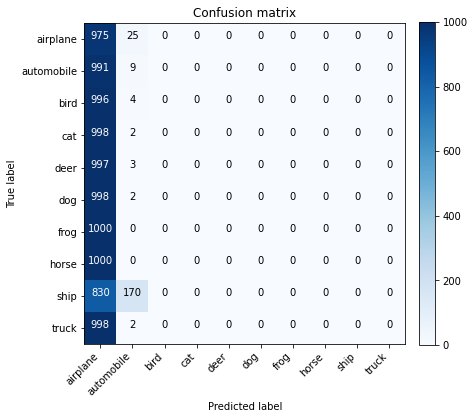

In [26]:
cm = confusion_matrix(y2, y2e)
plot_confusion_matrix(
    cm,
    classes=[
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ],
)


# Example preview

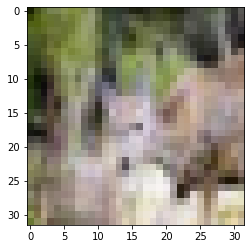

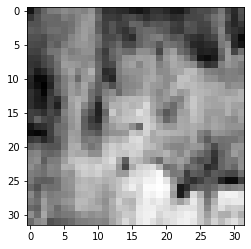

4


In [27]:
plot(Xtrain[0])
plot(XtrainG[0])
print(ytrain[0])
